In [1]:
import torch

import commons
import utils
from models import SynthesizerTrn
from text.symbols import symbols
from text import text_to_sequence
import random
from pathlib import Path
import librosa

from IPython.display import Audio
import matplotlib.pyplot as plt

DEBUG:matplotlib:matplotlib data path: /home/minhanh/anaconda3/envs/voice/lib/python3.9/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/home/minhanh/.config/matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', '_io', 'marshal', 'posix', '_frozen_importlib_external', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', 'encodings.latin_1', '_abc', 'abc', 'io', '__main__', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib.machinery', '_heapq', 'heapq', 'itertools', 'keyword', '_operator', 'operator', 'reprlib', '_collections', 'collections', 'collections.abc', '_functools', 'functools', 'contextlib', '

DEBUG:matplotlib:CACHEDIR=/home/minhanh/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/minhanh/.cache/matplotlib/fontlist-v330.json


In [2]:
def get_text(text, hps):
    text_norm = text_to_sequence(text, hps.data.text_cleaners)
#     text_norm = text_to_sequence(text, ["english_cleaners2"])
    if hps.data.add_blank:
        text_norm = commons.intersperse(text_norm, 0)
    text_norm = torch.LongTensor(text_norm)
    return text_norm

def load_data(path):
    au, sr = librosa.load(path)
    embed_ref = torch.load(path.replace(".wav", ".emb.pt").replace("dataset", "embed"), "cpu")
    return au, sr, embed_ref.unsqueeze(0)

def choose_ref(only_vivo=False):
    # choose a person
    if only_vivo:
        spkr_id = str(random.randint(1, 46))
    else:
        spkr_id = random.choice(keys)
    
    # choose a path
    path = random.choice(spkr_dict[spkr_id])
    path = "../data/dataset/" + path
    
    # load data
    return path, load_data(path)

In [3]:
with open("./filelists/my_val_filelist.txt.cleaned", "r") as f:
    data = f.readlines()
data = [line.split("|")[:2] for line in data]

In [4]:
spkr_dict = {}
for path, id in data:
    if id not in spkr_dict:
        spkr_dict[id] = [path]
    else:
        spkr_dict[id].append(path)

In [5]:
keys = list(spkr_dict.keys())

In [6]:
hps = utils.get_hparams_from_file("./configs/my_base.json")
net_g = SynthesizerTrn(
    len(symbols),
    hps.data.filter_length // 2 + 1,
    hps.train.segment_size // hps.data.hop_length,
    **hps.model).cpu()
net_g.eval()

utils.load_checkpoint("../checkpoints/exp1/last_gen.pth", net_g, None)

INFO:root:Loaded checkpoint '../checkpoints/exp1/last_gen.pth' (iteration 44000)


(SynthesizerTrn(
   (enc_p): TextEncoder(
     (emb): Embedding(192, 192)
     (encoder): Encoder(
       (drop): Dropout(p=0.1, inplace=False)
       (attn_layers): ModuleList(
         (0): MultiHeadAttention(
           (conv_q): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
           (conv_k): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
           (conv_v): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
           (conv_o): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
           (drop): Dropout(p=0.1, inplace=False)
         )
         (1): MultiHeadAttention(
           (conv_q): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
           (conv_k): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
           (conv_v): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
           (conv_o): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
           (drop): Dropout(p=0.1, inplace=False)
         )
         (2): MultiHeadAttention(
           (conv_q): Conv1d(192, 192, kernel_siz

In [64]:
real_au, sr, embed_ref = load_data("../data/dataset/VIVO/VIVOSSPK38_003.wav")
# real_au, sr, embed_ref = load_data("../data/dataset/JVS/jvs001/BASIC5000_1356.wav")
# path, (real_au, sr, embed_ref) = choose_ref(only_vivo=False)
print(path)

../data/dataset/VCTK/p306/p306_041.wav


In [69]:
# text = "xin chào mọi người tôi tên là Alice"
text = "haha no watashi wa"
# text = "hello everyone my name is Alice"
stn_tst = get_text(text, hps)
with torch.no_grad():
    x_tst = stn_tst.cpu().unsqueeze(0)
    x_tst_lengths = torch.LongTensor([stn_tst.size(0)]).cpu()
    # o = net_g.infer(x_tst, x_tst_lengths, embed_ref, noise_scale=.5, noise_scale_w=0.5, length_scale=1)
    fake_au = net_g.infer(x_tst, x_tst_lengths, embed_ref, noise_scale=0.6, noise_scale_w=0.8, length_scale=1)[0][0,0].data.cpu().float().numpy()

Text(0.5, 1.0, 'Fake Audio')

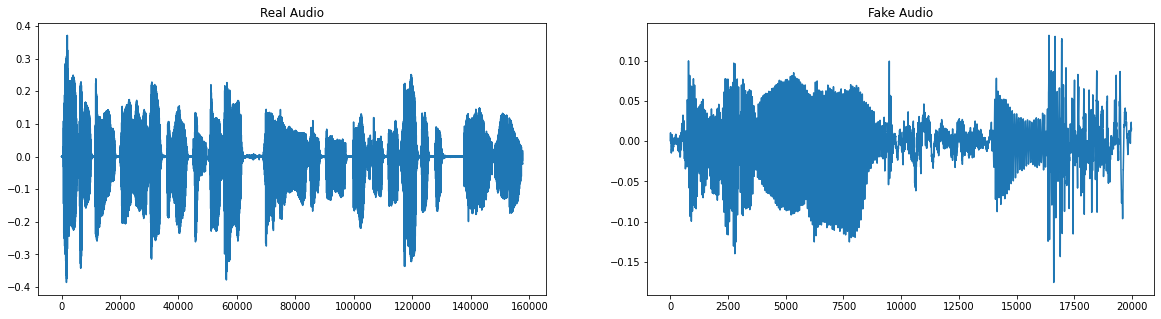

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(real_au)
ax[0].set_title("Real Audio")
ax[1].plot(fake_au)
ax[1].set_title("Fake Audio")

In [71]:
# real voice
Audio(data=real_au, rate=sr)

In [72]:
# gnerated voice
Audio(data=fake_au, rate=sr)